## This model replicates the example used in: Kruschke, John (2013) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General. 

## Implementation according to https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/BEST.html  

### This implementation changed the prior for the group standard deviations from Kruschke’s original model to Uniform(1,10) which is more specific. However, in order to keep the consistency over all BEST procedures in our paper, the original prior as in Kruschke’s (2013) paper was used: Uniform(μ_s/1000, μ_s* 1000).


In [22]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pickle

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [24]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams.update({"plot.point_estimate": "mode", "stats.hdi_prob": 0.95})

#### Read the data file and plot

/opt/tljh/user/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:298: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  bottom=0.15, top=0.9, left=0.1, right=0.9, hspace=0.5, wspace=0.3


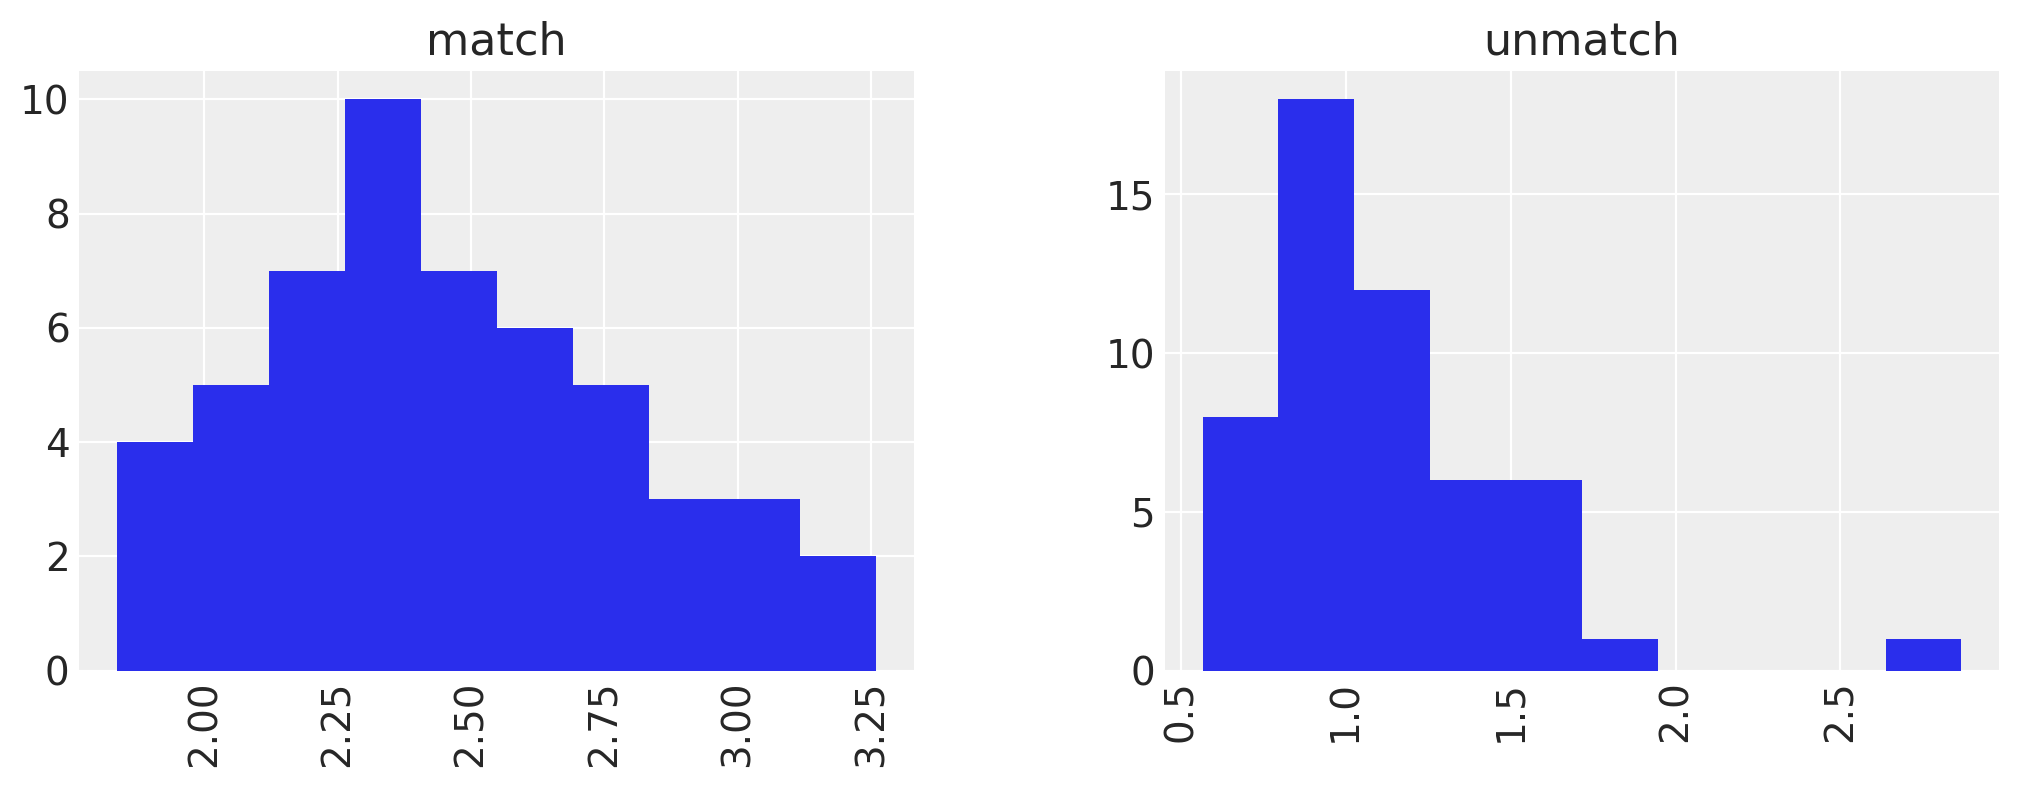

In [55]:
data = pd.read_csv('MuEtAl-2022-Exp1-Lab-EyetrackingDataPlateaus.csv')

# Three group comparisons for uniuqe target selected

#match = data['optimal_selected_optimal_first_fixation'].to_numpy()
#unmatch = data['optimal_selected_nonoptimal_first_fixation'].to_numpy()

#match = data['optimal_selected_optimal_last_fixation'].to_numpy()
#unmatch = data['optimal_selected_nonoptimal_last_fixation'].to_numpy()

#match = data['optimal_selected_optimal_total_fixation'].to_numpy()
#unmatch = data['optimal_selected_nonoptimal_total_fixation'].to_numpy()

# Three group comparisons for Non-uniuqe target selected

#unmatch = data['nonoptimal_selected_optimal_first_fixation'].to_numpy()
#match = data['nonoptimal_selected_nonoptimal_first_fixation'].to_numpy()

#unmatch = data['nonoptimal_selected_optimal_last_fixation'].to_numpy()
#match = data['nonoptimal_selected_nonoptimal_last_fixation'].to_numpy()

unmatch = data['nonoptimal_selected_optimal_total_fixation'].to_numpy()
match = data['nonoptimal_selected_nonoptimal_total_fixation'].to_numpy()

y = pd.DataFrame(
    dict(value=np.r_[unmatch, match], group=np.r_[["unmatch"] * len(unmatch), ["match"] * len(match)])
)


#### Run the BEST procedure and save the result as .nc file. To skip the running process, you can directly open the .nc file saved in in the next cell. 

In [56]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

σ_low = μ_s/1000
σ_high = μ_s * 1000

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=μ_m, sigma=μ_s)
    group2_mean = pm.Normal("group2_mean", mu=μ_m, sigma=μ_s)
    group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)
    
    ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1
    λ1 = group1_std ** -2
    λ2 = group2_std ** -2

    group1 = pm.StudentT("match", nu=ν, mu=group1_mean, lam=λ1, observed=match)
    group2 = pm.StudentT("unmatch", nu=ν, mu=group2_mean, lam=λ2, observed=unmatch)
    
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
    )
    
    idata = pm.sample(20000,tune=1000, random_seed = 1234, return_inferencedata=True)
    
#idata.to_netcdf('UniuqeSelectedFirstFixation.nc')
#idata.to_netcdf('UniuqeSelectedLastFixation.nc')
#idata.to_netcdf('UniuqeSelectedTotalFixation.nc')
#idata.to_netcdf('Non-uniuqeSelectedFirstFixation.nc')
#idata.to_netcdf('Non-uniuqeSelectedLastFixation.nc')
idata.to_netcdf('Non-uniuqeSelectedTotalFixation.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group1_mean, group2_mean, group1_std, group2_std, ν_minus_one]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 26 seconds.


'Non-uniuqeSelectedTotalFixation.nc'

In [57]:
idata = az.from_netcdf('Non-uniuqeSelectedTotalFixation.nc')

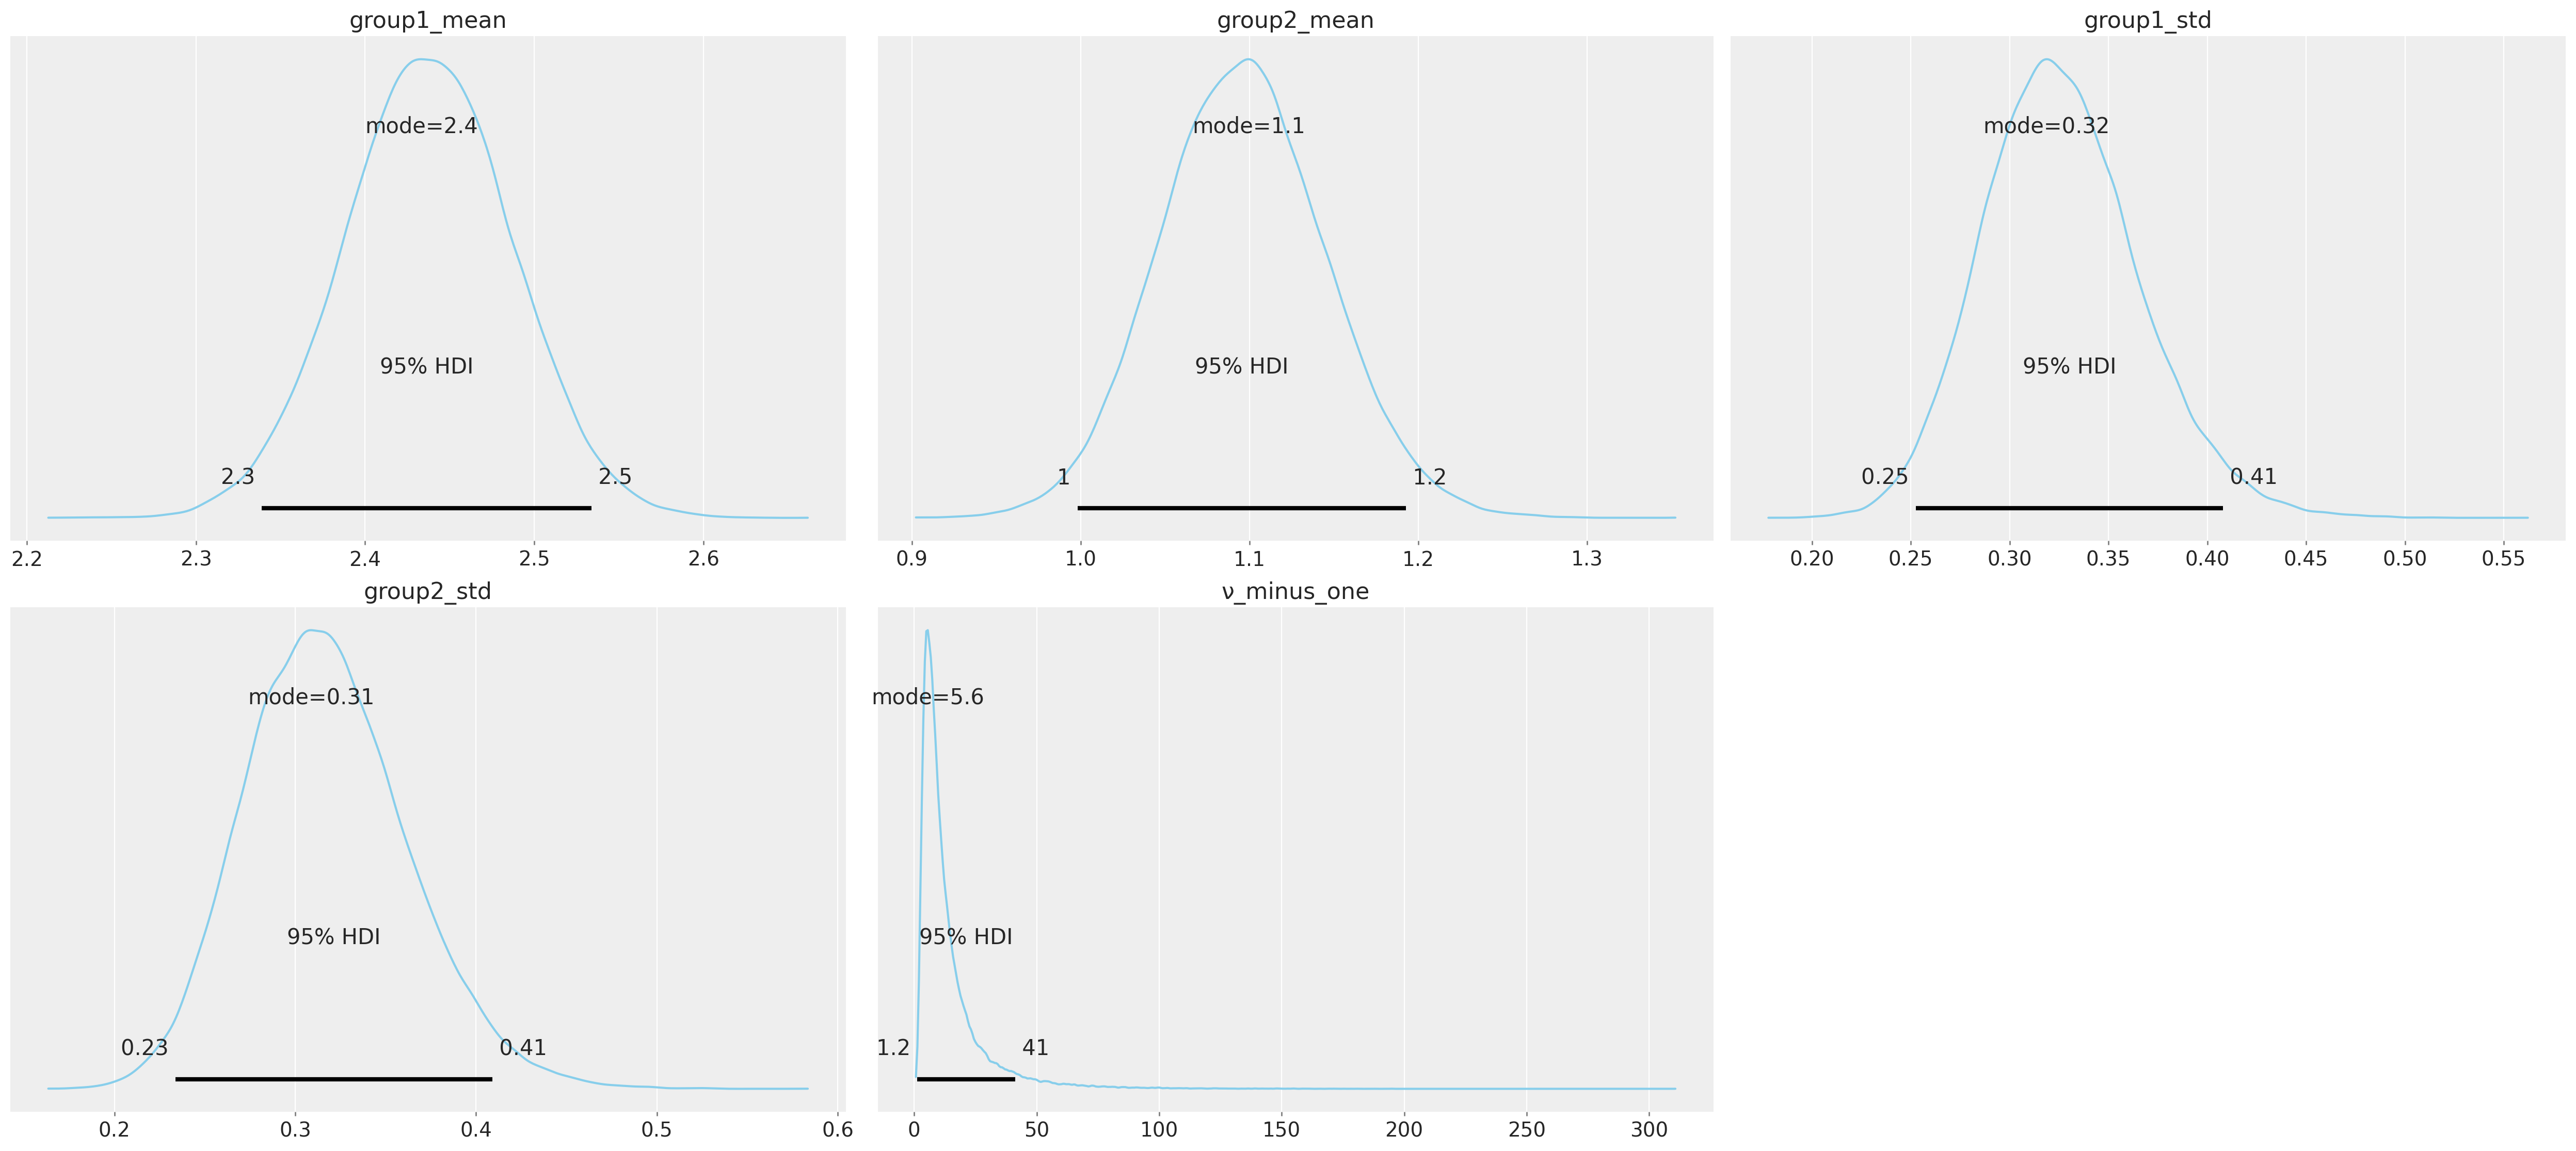

In [58]:
az.plot_posterior(
    idata,
    var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "ν_minus_one"],
    color="#87ceeb",
);

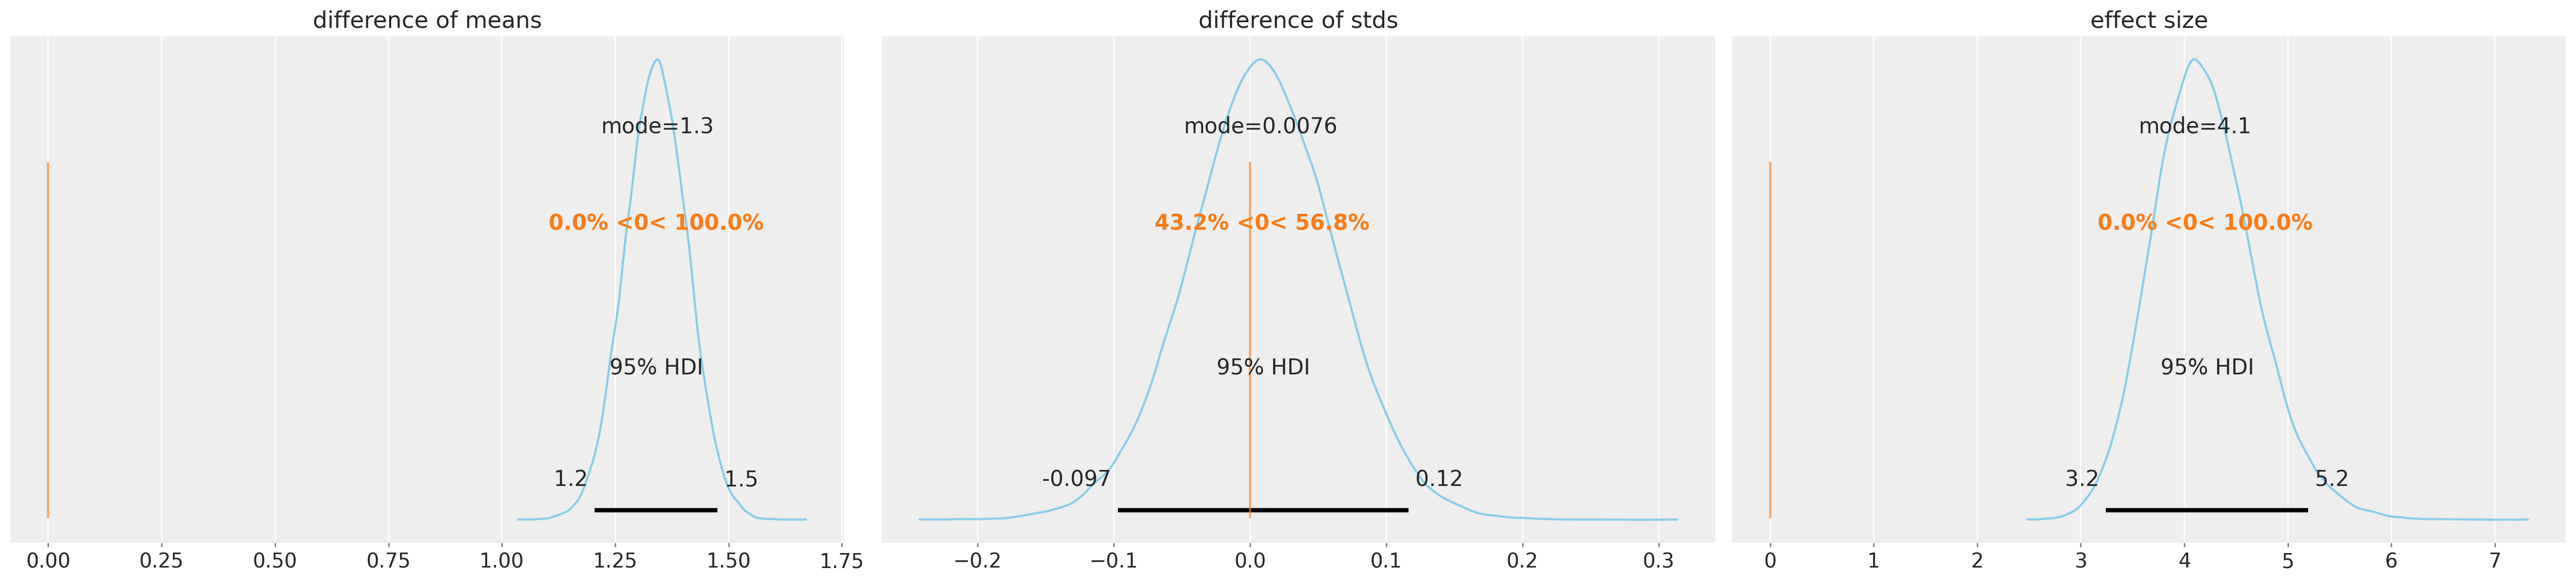

In [59]:
az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);